# Proyecto Final de Inteligencia Artificial
## Redes convolucionales para clasificar dos tipos de cancer no melanomatoso



##### Imports

In [1]:
import os
import json

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd

from keras import layers
from keras import models
from keras.models import load_model
from tensorflow.keras import optimizers
from keras.applications.vgg16 import VGG16 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import StratifiedKFold

2022-06-28 22:43:43.546056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-28 22:43:43.546166: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


#### Utils

In [2]:
def save_dict_as_json(data, file_name):
    with open(file_name + ".json", "w") as fp:
        json.dump(data,fp, indent = 4) 

##### Show validation and accuracy measures

In [3]:
def show_accuracies(histories):
    for history in histories:
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        print("Accuracy: ", np.mean(acc), "Validation Accuracy: ", np.mean(val_acc), "\n",
              "Loss: ", np.mean(loss), "Validation Loss: ",np.mean(val_loss), "\n")

##### Plot training and validation graphics

In [4]:
def plot_graphs(history, smooth = False):
    
    def smooth_curve(points, factor=0.8):
        smoothed_points = []
        for point in points:
            if smoothed_points:
                previous = smoothed_points[-1]
                smoothed_points.append(previous * factor + point * (1 - factor))
            else:
                smoothed_points.append(point)
        return smoothed_points
   
    acc = smooth_curve(history['acc']) if smooth else history['acc']
    val_acc = smooth_curve(history['val_acc']) if smooth else history['val_acc']
    loss = smooth_curve(history['loss']) if smooth else history['loss']
    val_loss = smooth_curve(history['val_loss']) if smooth else history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    

### Construyendo el modelo

Modelo para entrenamiento end-to-end con 4 capas convolucionales alternando con capas de MaxPooling.
Para el clasificador se utiliza una capa Flatten seguida de dos capas totalmente conectadas.

##### Data global variables

In [38]:
original_dataset_directory = 'images'

base_directory = 'database'

train_dir = os.path.join(base_directory, 'train')
test_dir = os.path.join(base_directory, 'test')
test_data = os.listdir(test_dir)

train_basal_dir = os.path.join(train_dir, 'basal')
train_basal_data = os.listdir(train_basal_dir)
train_basal_labels = ["basal" for _ in range(len(train_basal_data))]
train_squamous_dir = os.path.join(train_dir, 'squamous')
train_squamous_data = os.listdir(train_squamous_dir)
train_squamous_labels = ["squamous" for _ in range(len(train_squamous_data))]

train_data = [os.path.join(train_basal_dir,item) for item in train_basal_data]
train_data += [os.path.join(train_squamous_dir,item) for item in train_squamous_data]
train_labels = train_basal_labels + train_squamous_labels

test_basal_dir = os.path.join(test_dir, 'basal')
test_squamous_dir = os.path.join(test_dir, 'squamous')

##### Database information

In [39]:
print('Total training basal cell carcinoma images:', len(os.listdir(train_basal_dir)))
print('Total training squamous cell carcinoma images:', len(os.listdir(train_squamous_dir)))
print('Total test basal cell carcinoma images:', len(os.listdir(test_basal_dir)))
print('Total test squamous cell carcinoma images:', len(os.listdir(test_squamous_dir)))

Total training basal cell carcinoma images: 1031
Total training squamous cell carcinoma images: 450
Total test basal cell carcinoma images: 516
Total test squamous cell carcinoma images: 225


In [42]:
def build_scratch_model():
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
    return model

In [43]:
model = build_scratch_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 128)     

Convertir las imagenes de valores en el rango [0-255] al rango [0-1]

In [44]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

##### K-Fold validation

Debido a la poca cantidad de imágenes se utiliza la técnica K-Fold. En este caso como las imágenes de cada clase están desbalanceadas resulta mejor utilizar Stratified K-Fold, que logra mantener una cantidad similar de clases en cada fold.

In [45]:
skfold = StratifiedKFold(n_splits = 5, random_state = 7, shuffle = True) 

In [46]:
histories = []
i = 1

for train_index, test_index in skfold.split(train_data, train_labels):
    print('Processing fold: ', i )
    training_data = np.asarray(train_data)[train_index]
    validation_data = np.asarray(train_data)[test_index]
    training_target = np.asarray(train_labels)[train_index]
    validation_target = np.asarray(train_labels)[test_index]
    
    data_train = {'filename': training_data, 'label': training_target}
    data_train = pd.DataFrame(data=data_train)
    
    data_validation = {'filename': validation_data, 'label': validation_target}
    data_validation = pd.DataFrame(data=data_validation)
    
    train_data_generator = train_datagen.flow_from_dataframe(data_train,
                                                            x_col = "filename",
                                                            y_col = "label",
                                                            target_size=(224, 224),
                                                            class_mode = "binary", 
                                                            shuffle = True, 
                                                            batch_size = 8)
   
    validation_data_generator = test_datagen.flow_from_dataframe(data_validation,
                                                            x_col = "filename",
                                                            y_col = "label",
                                                            target_size=(224, 224),
                                                            class_mode = "binary", 
                                                            shuffle = True, 
                                                            batch_size = 8)
    model = build_scratch_model()
    history = model.fit(train_data_generator,
                        epochs=40,
                        validation_data=validation_data_generator)
    histories.append(history)
    
    i += 1
    #plot_graphs(history)
    
   

Processing fold:  1
Found 1184 validated image filenames belonging to 2 classes.
Found 297 validated image filenames belonging to 2 classes.
Epoch 1/40
148/148 [==============================] - 110s 736ms/step - loss: 0.6298 - acc: 0.6892 - val_loss: 0.6134 - val_acc: 0.6970
Epoch 2/40
148/148 [==============================] - 109s 741ms/step - loss: 0.6237 - acc: 0.6959 - val_loss: 0.6375 - val_acc: 0.6970
Epoch 3/40
148/148 [==============================] - 108s 729ms/step - loss: 0.6096 - acc: 0.6959 - val_loss: 0.6173 - val_acc: 0.6970
Epoch 4/40
148/148 [==============================] - 112s 757ms/step - loss: 0.6088 - acc: 0.7019 - val_loss: 0.6166 - val_acc: 0.6700
Epoch 5/40
148/148 [==============================] - 117s 792ms/step - loss: 0.6002 - acc: 0.6959 - val_loss: 0.6172 - val_acc: 0.6970
Epoch 6/40
148/148 [==============================] - 114s 768ms/step - loss: 0.5965 - acc: 0.7095 - val_loss: 0.6170 - val_acc: 0.6734
Epoch 7/40
148/148 [=======================

149/149 [==============================] - 82s 549ms/step - loss: 0.0752 - acc: 0.9747 - val_loss: 2.2295 - val_acc: 0.6351
Epoch 39/40
149/149 [==============================] - 85s 570ms/step - loss: 0.0544 - acc: 0.9831 - val_loss: 2.6173 - val_acc: 0.6486
Epoch 40/40
149/149 [==============================] - 86s 575ms/step - loss: 0.0536 - acc: 0.9840 - val_loss: 2.3586 - val_acc: 0.6757
Processing fold:  4
Found 1185 validated image filenames belonging to 2 classes.
Found 296 validated image filenames belonging to 2 classes.
Epoch 1/40
149/149 [==============================] - 84s 560ms/step - loss: 0.6378 - acc: 0.6928 - val_loss: 0.6137 - val_acc: 0.6959
Epoch 2/40
149/149 [==============================] - 83s 559ms/step - loss: 0.6290 - acc: 0.6962 - val_loss: 0.6110 - val_acc: 0.6959
Epoch 3/40
149/149 [==============================] - 82s 549ms/step - loss: 0.6305 - acc: 0.6920 - val_loss: 0.6113 - val_acc: 0.6959
Epoch 4/40
149/149 [==============================] - 83s 

In [47]:
show_accuracies(histories)
save_dict_as_json([history.history for history in histories], 'end_to_end_40_histories')

Accuracy:  0.8425886809825898 Validation Accuracy:  0.696885521709919 
 Loss:  0.3421113687567413 Validation Loss:  0.9688829839229584 

Accuracy:  0.8371307998895645 Validation Accuracy:  0.6941722899675369 
 Loss:  0.35566213056445123 Validation Loss:  0.9050634428858757 

Accuracy:  0.84118143171072 Validation Accuracy:  0.6619087845087052 
 Loss:  0.3452318452298641 Validation Loss:  1.1362787336111069 

Accuracy:  0.823734174668789 Validation Accuracy:  0.695945942401886 
 Loss:  0.3784921080805361 Validation Loss:  0.8206402882933617 

Accuracy:  0.8152953535318375 Validation Accuracy:  0.7066722929477691 
 Loss:  0.3970954118296504 Validation Loss:  0.7047660142183304 



__Plotting histories of each fold:__

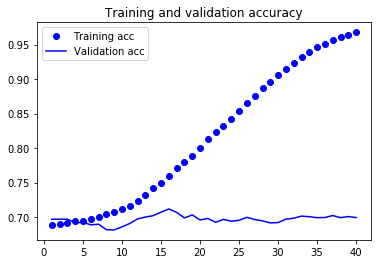

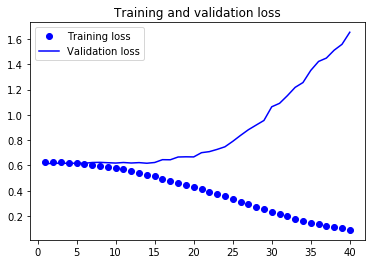

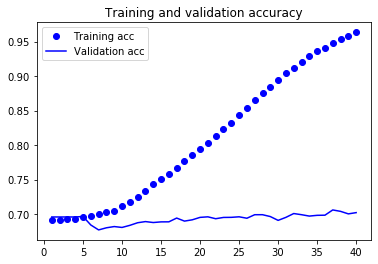

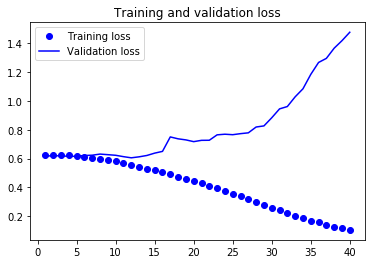

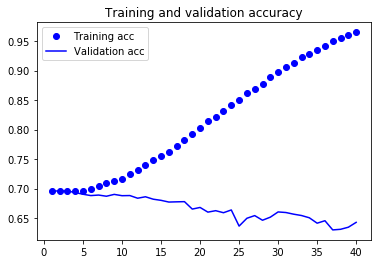

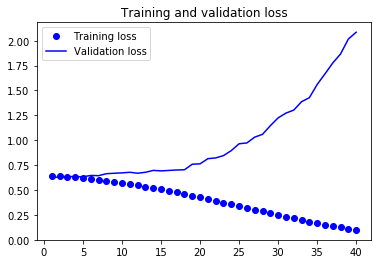

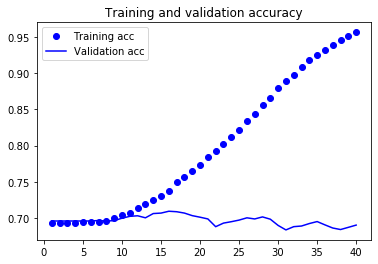

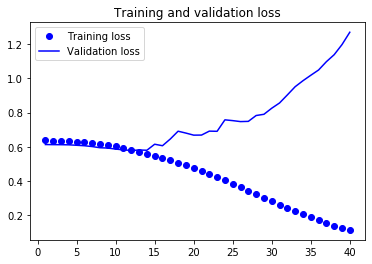

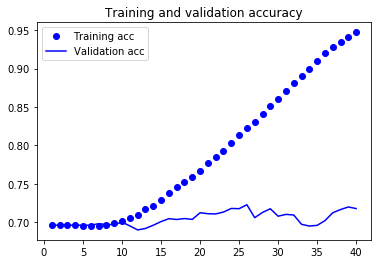

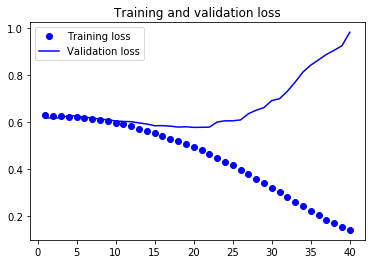

In [48]:
for item in histories:
    plot_graphs(item.history, True)

__Plotting history of mean accuracy, validation accuracy, loss and validation loss for each epoch:__


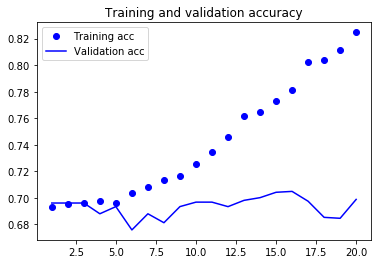

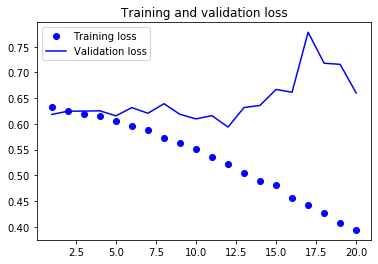

In [49]:
epochs = 20
data = {}
acc = [0 for _ in range(epochs)]
val_acc = [0 for _ in range(epochs)]
loss = [0 for _ in range(epochs)]
val_loss = [0 for _ in range(epochs)]

for epoch in range(epochs):
    acc[epoch] = np.mean([history.history['acc'][epoch] for history in histories])
    val_acc[epoch] = np.mean([history.history['val_acc'][epoch] for history in histories])
    loss[epoch] = np.mean([history.history['loss'][epoch] for history in histories])
    val_loss[epoch] = np.mean([history.history['val_loss'][epoch] for history in histories])

data["acc"] = acc
data["val_acc"] = val_acc
data['loss'] = loss
data['val_loss'] = val_loss
plot_graphs(data)
    

##### Evaluating the results

In [50]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                                test_dir,
                                target_size=(224, 224),
                                batch_size=20,
                                class_mode='binary')

results = model.evaluate(test_generator)

Found 741 images belonging to 2 classes.
38/38 [==============================] - 24s 601ms/step - loss: 1.5496 - acc: 0.6788


In [51]:
print(model.metrics_names)
print(results)

['loss', 'acc']
[1.549623966217041, 0.6788124442100525]


##### Saving the model

In [52]:
model.save('cancer_classification_end_to_end_40.h5')

## Model with data augmentation

##### Image data generators with augmentation

Setting global variables paths for validation folder

In [53]:
base_directory = 'image_database'
train_dir = os.path.join(base_directory, 'train')
test_dir = os.path.join(base_directory, 'test')
validation_dir = os.path.join(base_directory, 'validation')

train_basal_dir = os.path.join(train_dir, 'basal')
train_basal_data = os.listdir(train_basal_dir)
train_basal_labels = ["basal" for _ in range(len(train_basal_data))]
test_basal_dir = os.path.join(test_dir, 'basal')
validation_basal_dir = os.path.join(validation_dir, 'basal')

train_squamous_dir = os.path.join(train_dir, 'squamous')
train_squamous_data = os.listdir(train_squamous_dir)
train_squamous_labels = ["squamous" for _ in range(len(train_squamous_data))]
test_squamous_dir = os.path.join(test_dir, 'squamous')
validation_squamous_dir = os.path.join(validation_dir, 'squamous')
size = (224,224)

In [23]:
# Image data generator to increase the size of data samples
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=360,
                horizontal_flip=True,
                vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=size,
                    batch_size=8,
                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                        validation_dir,
                        target_size=size,
                        batch_size=8,
                        class_mode='binary')


Found 1110 images belonging to 2 classes.
Found 556 images belonging to 2 classes.


In [56]:
model = build_scratch_model()
history = model.fit(train_generator,
                    epochs=40,
                    validation_data=validation_generator)

Epoch 1/40
139/139 [==============================] - 118s 842ms/step - loss: 0.6398 - acc: 0.6946 - val_loss: 0.6179 - val_acc: 0.6960
Epoch 2/40
139/139 [==============================] - 119s 844ms/step - loss: 0.6190 - acc: 0.6964 - val_loss: 0.6628 - val_acc: 0.6960
Epoch 3/40
139/139 [==============================] - 122s 879ms/step - loss: 0.6187 - acc: 0.6964 - val_loss: 0.6209 - val_acc: 0.6960
Epoch 4/40
139/139 [==============================] - 121s 870ms/step - loss: 0.6092 - acc: 0.6964 - val_loss: 0.6191 - val_acc: 0.6960
Epoch 5/40
139/139 [==============================] - 126s 904ms/step - loss: 0.6048 - acc: 0.6973 - val_loss: 0.6201 - val_acc: 0.6960
Epoch 6/40
139/139 [==============================] - 129s 928ms/step - loss: 0.6009 - acc: 0.6955 - val_loss: 0.6283 - val_acc: 0.6960
Epoch 7/40
139/139 [==============================] - 125s 901ms/step - loss: 0.5993 - acc: 0.6964 - val_loss: 0.6155 - val_acc: 0.6960
Epoch 8/40
139/139 [============================

In [57]:
model.save('cancer_classification_data_augmentation_40.h5')

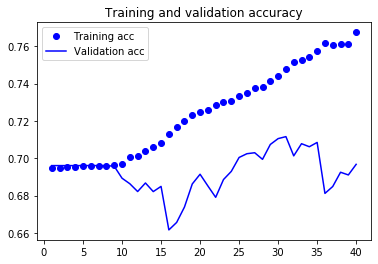

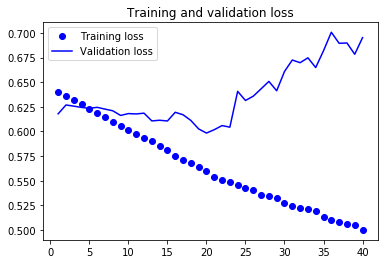

In [58]:
plot_graphs(history.history, True)

In [59]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                                test_dir,
                                target_size=size,
                                batch_size=16,
                                class_mode='binary')

results = model.evaluate(test_generator)

Found 556 images belonging to 2 classes.
35/35 [==============================] - 35s 1s/step - loss: 0.7053 - acc: 0.6835


In [60]:
print(model.metrics_names)
print(results)

['loss', 'acc']
[0.7052786350250244, 0.6834532618522644]


## Transfer Learning

### Feature extraction

In [18]:
base_directory = 'image_database'
train_dir = os.path.join(base_directory, 'train')
test_dir = os.path.join(base_directory, 'test')
validation_dir = os.path.join(base_directory, 'validation')

train_basal_dir = os.path.join(train_dir, 'basal')
train_basal_data = os.listdir(train_basal_dir)
train_basal_labels = ["basal" for _ in range(len(train_basal_data))]
test_basal_dir = os.path.join(test_dir, 'basal')
validation_basal_dir = os.path.join(validation_dir, 'basal')

train_squamous_dir = os.path.join(train_dir, 'squamous')
train_squamous_data = os.listdir(train_squamous_dir)
train_squamous_labels = ["squamous" for _ in range(len(train_squamous_data))]
test_squamous_dir = os.path.join(test_dir, 'squamous')
validation_squamous_dir = os.path.join(validation_dir, 'squamous')
size = (224,224)

In [19]:
# Image data generator to increase the size of data samples
train_datagen = ImageDataGenerator(
                rescale=1./255,
                rotation_range=360,
                horizontal_flip=True,
                vertical_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=size,
                    batch_size=8,
                    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                        validation_dir,
                        target_size=size,
                        batch_size=8,
                        class_mode='binary')


Found 1110 images belonging to 2 classes.
Found 556 images belonging to 2 classes.


In [20]:
def build_VGG_feature_extraction_model():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable = False
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer= optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
    return model

In [21]:
model = build_VGG_feature_extraction_model()
history = model.fit(train_generator,  
                    epochs=25,
                    validation_data=validation_generator)

Epoch 1/25
139/139 [==============================] - 441s 3s/step - loss: 0.7275 - acc: 0.6333 - val_loss: 0.6596 - val_acc: 0.6960
Epoch 2/25
139/139 [==============================] - 435s 3s/step - loss: 0.6359 - acc: 0.6811 - val_loss: 0.6098 - val_acc: 0.6996
Epoch 3/25
139/139 [==============================] - 430s 3s/step - loss: 0.5992 - acc: 0.6982 - val_loss: 0.6079 - val_acc: 0.6978
Epoch 4/25
139/139 [==============================] - 430s 3s/step - loss: 0.5972 - acc: 0.7027 - val_loss: 0.6069 - val_acc: 0.6960
Epoch 5/25
139/139 [==============================] - 437s 3s/step - loss: 0.5814 - acc: 0.7108 - val_loss: 0.5975 - val_acc: 0.7068
Epoch 6/25
139/139 [==============================] - 434s 3s/step - loss: 0.5681 - acc: 0.7198 - val_loss: 0.6183 - val_acc: 0.6960
Epoch 7/25
139/139 [==============================] - 439s 3s/step - loss: 0.5895 - acc: 0.7135 - val_loss: 0.5946 - val_acc: 0.6906
Epoch 8/25
139/139 [==============================] - 439s 3s/step - 

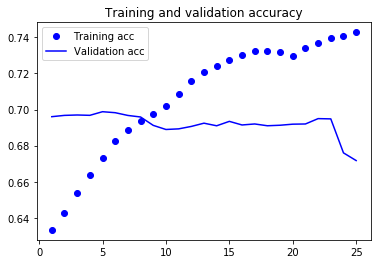

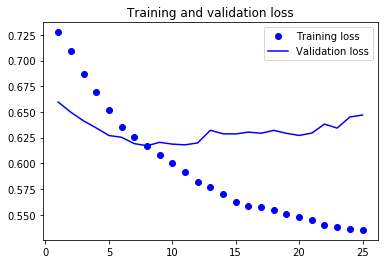

In [26]:
plot_graphs(history.history, True)

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
                                test_dir,
                                target_size=(224, 224),
                                batch_size=8,
                                class_mode='binary')

results = model.evaluate(test_generator)
print(model.metrics_names)
print(results)

Found 556 images belonging to 2 classes.
70/70 [==============================] - 143s 2s/step - loss: 0.6668 - acc: 0.6151
['loss', 'acc']
[0.6668352484703064, 0.6151078939437866]


In [24]:
save_dict_as_json(history.history,"cancer_classification_vgg6_25_history")

In [25]:
model.save("cancer_classification_vgg6_25.h5")

## Fine Tuning
 

Se vuelven a calcular los pesos de capas superiores y se entrenar entonces, estas capas y el modelo clasificador añadido

In [16]:
def build_model_fine_tuning():
    conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable = True
    set_trainable = False

    for layer in conv_base.layers:
        if layer.name == 'block5_conv1':
            set_trainable = True
        if set_trainable:
            layer.trainable = True
        else:
            layer.trainable = False
    
    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))    
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])
    return model

In [17]:
model = build_model_fine_tuning()
history = model.fit(train_generator,
                    epochs=25,
                    validation_data=validation_generator)

Epoch 1/25
139/139 [==============================] - 604s 4s/step - loss: 0.6486 - acc: 0.6676 - val_loss: 0.5967 - val_acc: 0.6942
Epoch 2/25
139/139 [==============================] - 595s 4s/step - loss: 0.5743 - acc: 0.7081 - val_loss: 0.6569 - val_acc: 0.6511
Epoch 3/25
139/139 [==============================] - 578s 4s/step - loss: 0.5527 - acc: 0.7450 - val_loss: 0.5829 - val_acc: 0.7014
Epoch 4/25
139/139 [==============================] - 584s 4s/step - loss: 0.5196 - acc: 0.7523 - val_loss: 0.5830 - val_acc: 0.6924
Epoch 5/25
139/139 [==============================] - 581s 4s/step - loss: 0.4891 - acc: 0.7640 - val_loss: 0.6263 - val_acc: 0.7068
Epoch 6/25
139/139 [==============================] - 571s 4s/step - loss: 0.4875 - acc: 0.7757 - val_loss: 0.5872 - val_acc: 0.7068
Epoch 7/25
139/139 [==============================] - 575s 4s/step - loss: 0.4857 - acc: 0.7685 - val_loss: 0.7527 - val_acc: 0.7104
Epoch 8/25
139/139 [==============================] - 562s 4s/step - 

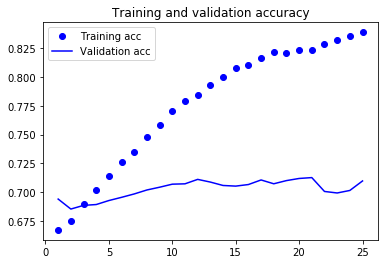

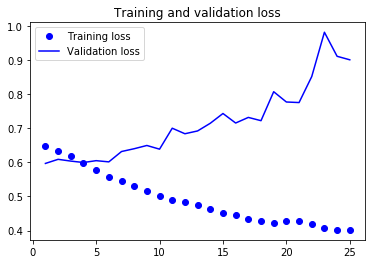

In [20]:
plot_graphs(history.history, True)

In [21]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
                                test_dir,
                                target_size=size,
                                batch_size=8,
                                class_mode='binary')
test_loss, test_acc = model.evaluate(test_generator)
print('test loss:', test_loss)
print('test acc:', test_acc)

Found 556 images belonging to 2 classes.
70/70 [==============================] - 169s 2s/step - loss: 1.0604 - acc: 0.7032
test loss: 1.0603963136672974
test acc: 0.7032374143600464


In [18]:
save_dict_as_json(history.history, "cancer_classification_vgg16_fine_tuning_history_25")
model.save("cancer_classification_vgg16_fine_tuning_25.h5")

# Adding Metadata


In [5]:
from tensorflow.keras.preprocessing import image
def load_image(img_path, show=False):

    img = image.load_img(img_path, target_size=(224, 224))
    img_tensor = image.img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255
    
    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [6]:
base_directory = 'image_database'
train_dir = os.path.join(base_directory, 'train')
test_dir = os.path.join(base_directory, 'test')
validation_dir = os.path.join(base_directory, 'validation')

train_basal_dir = os.path.join(train_dir, 'basal')
train_basal_data = os.listdir(train_basal_dir)
train_basal_labels = ["basal" for _ in range(len(train_basal_data))]
test_basal_dir = os.path.join(test_dir, 'basal')
validation_basal_dir = os.path.join(validation_dir, 'basal')
validation_basal_data = os.listdir(validation_basal_dir)
validation_basal_labels = ["basal" for _ in range(len(validation_basal_data))]

train_squamous_dir = os.path.join(train_dir, 'squamous')
train_squamous_data = os.listdir(train_squamous_dir)
train_squamous_labels = ["squamous" for _ in range(len(train_squamous_data))]
test_squamous_dir = os.path.join(test_dir, 'squamous')
validation_squamous_dir = os.path.join(validation_dir, 'squamous')
validation_squamous_data = os.listdir(validation_squamous_dir)
validation_squamous_labels = ["squamous" for _ in range(len(validation_squamous_data))]

size = (224,224)

base_database_directory = 'images'
train_basal_images = []
train_basal_metadata = []
for file in train_basal_data:
    image_directory = os.path.join(train_basal_dir, file)
    train_basal_images.extend(load_image(image_directory))

    name, _ = file.split('.')
    directory = os.path.join(base_database_directory, 'basal', name, f'{name}.json')
    with open(directory, 'r') as f:
        train_basal_metadata.append(json.load(f)['metadata']['clinical'])
        
        
validation_basal_images = []
validation_basal_metadata = []
for file in validation_basal_data:
    image_directory = os.path.join(validation_basal_dir, file)
    validation_basal_images.extend(load_image(image_directory))

    name, _ = file.split('.')
    directory = os.path.join(base_database_directory, 'basal', name, f'{name}.json')
    with open(directory, 'r') as f:
        validation_basal_metadata.append(json.load(f)['metadata']['clinical'])
        
        
train_squamous_images = []
train_squamous_metadata = []
for file in train_squamous_data:
    image_directory = os.path.join(train_squamous_dir, file)
    train_squamous_images.extend(load_image(image_directory))

    name, _ = file.split('.')
    directory = os.path.join(base_database_directory, 'squamous', name, f'{name}.json')
    with open(directory, 'r') as f:
        train_squamous_metadata.append(json.load(f)['metadata']['clinical'])
        
validation_squamous_images = []
validation_squamous_metadata = []
for file in validation_squamous_data:
    image_directory = os.path.join(validation_squamous_dir, file)
    validation_squamous_images.extend(load_image(image_directory))

    name, _ = file.split('.')
    directory = os.path.join(base_database_directory, 'squamous', name, f'{name}.json')
    with open(directory, 'r') as f:
        validation_squamous_metadata.append(json.load(f)['metadata']['clinical'])
        
training_images = np.array(train_basal_images + train_squamous_images, dtype=np.float32)
training_metadata = train_basal_metadata + train_squamous_metadata
validation_images = np.array(validation_basal_images + validation_squamous_images, dtype=np.float32)
validation_metadata = validation_basal_metadata + validation_squamous_metadata

In [7]:
from tensorflow.keras.utils import to_categorical
from sklearn import preprocessing

sex_encoder = preprocessing.LabelEncoder()
age_encoder = preprocessing.LabelEncoder()
position_encoder = preprocessing.LabelEncoder()

def extract_metadata(arr, label):
    full = []
    for data in arr:
        try: full.append(str(data[label]))
        except: full.append('unknown')
    return full

train_sex = extract_metadata(training_metadata, 'sex')
train_age = extract_metadata(training_metadata, 'age_approx')
train_position = extract_metadata(training_metadata, 'anatom_site_general')

validation_sex = extract_metadata(validation_metadata, 'sex')
validation_age = extract_metadata(validation_metadata, 'age_approx')
validation_position = extract_metadata(validation_metadata, 'anatom_site_general')

sex_encoder.fit(train_sex + validation_sex + ['unknown'])
age_encoder.fit(train_age + validation_age + ['unknown'])
position_encoder.fit(train_position + validation_position + ['unknown'])

train_sex = to_categorical(sex_encoder.transform(train_sex), len(sex_encoder.classes_))
train_age = to_categorical(age_encoder.transform(train_age), len(age_encoder.classes_))
train_position = to_categorical(position_encoder.transform(train_position), len(position_encoder.classes_))

validation_sex = to_categorical(sex_encoder.transform(validation_sex), len(sex_encoder.classes_))
validation_age = to_categorical(age_encoder.transform(validation_age), len(age_encoder.classes_))
validation_position = to_categorical(position_encoder.transform(validation_position), len(position_encoder.classes_))

In [8]:
print(train_sex.shape, validation_sex.shape)

(1110, 3) (556, 3)


In [9]:
from keras import Input, Model
from tensorflow.keras.layers import concatenate

input_sex = Input(shape=(len(train_sex[0]),))
input_age = Input(shape=(len(train_age[0]),))
input_position = Input(shape=(len(train_position[0]),))
input_image = Input(shape=(224, 224, 3))

sex_model = layers.Dense(4, activation="relu")(input_sex)
sex_model = layers.Dense(2, activation="relu")(sex_model)
sex_model = Model(inputs=input_sex, outputs=sex_model)

age_model = layers.Dense(16, activation="relu")(input_age)
age_model = layers.Dense(8, activation="relu")(age_model)
age_model = layers.Dense(4, activation="linear")(age_model)
age_model = Model(inputs=input_age, outputs=age_model)

position_model = layers.Dense(4, activation="relu")(input_position)
position_model = layers.Dense(2, activation="relu")(position_model)
position_model = Model(inputs=input_position, outputs=position_model)

image_model = layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3))(input_image)
image_model = layers.MaxPooling2D((2, 2))(image_model)
image_model = layers.Conv2D(64, (3, 3), activation='relu')(image_model)
image_model = layers.MaxPooling2D((2, 2))(image_model)
image_model = layers.Conv2D(128, (3, 3), activation='relu')(image_model)
image_model = layers.MaxPooling2D((2, 2))(image_model)
image_model = layers.Conv2D(256, (3, 3), activation='relu')(image_model)
image_model = layers.MaxPooling2D((2, 2))(image_model)
image_model = layers.Flatten()(image_model)
image_model = Model(inputs=input_image, outputs=image_model)

combined = concatenate([sex_model.output, age_model.output, position_model.output, image_model.output])

model = layers.Dense(512, activation='relu')(combined)
model = layers.Dropout(0.5)(model)
model = layers.Dense(1, activation='sigmoid')(model)
model = Model(inputs=[sex_model.input, age_model.input, position_model.input, image_model.input], 
              outputs=model)
model.compile(loss='binary_crossentropy',optimizer=optimizers.RMSprop(learning_rate=1e-4), metrics=['acc'])

2022-06-28 22:44:45.501296: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-28 22:44:45.501351: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-28 22:44:45.501375: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-DH62PHK): /proc/driver/nvidia/version does not exist
2022-06-28 22:44:45.502689: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 222, 222, 32  896         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 111, 111, 32  0           ['conv2d[0][0]']                 
                                )                                                           

In [11]:
train_labels = train_basal_labels + train_squamous_labels
validation_labels = validation_basal_labels + validation_squamous_labels

train_labels = np.array([0 if label == 'basal' else 1 for label in train_labels], dtype=np.float32)
validation_labels = np.array([0 if label == 'basal' else 1 for label in validation_labels], dtype=np.float32)
training_images = np.array(training_images)
validation_images = np.array(validation_images)

In [12]:
print(train_sex.shape, validation_sex.shape)
print(train_age.shape, validation_age.shape)
print(train_position.shape, validation_position.shape)
print(training_images.shape, validation_images.shape)
print(train_labels.shape, validation_labels.shape)


(1110, 3) (556, 3)
(1110, 15) (556, 15)
(1110, 7) (556, 7)
(1110, 224, 224, 3) (556, 224, 224, 3)
(1110,) (556,)


In [13]:
history = model.fit(x = [train_sex, train_age, train_position, training_images], 
                    y = train_labels,
                    epochs=20,
                    validation_data=([validation_sex,validation_age, validation_position, validation_images], 
                                     validation_labels))

Epoch 1/20
35/35 [==============================] - 96s 3s/step - loss: 0.6309 - acc: 0.6820 - val_loss: 0.6352 - val_acc: 0.6960
Epoch 2/20
35/35 [==============================] - 90s 3s/step - loss: 0.6191 - acc: 0.6964 - val_loss: 0.6233 - val_acc: 0.6960
Epoch 3/20
35/35 [==============================] - 92s 3s/step - loss: 0.6060 - acc: 0.6964 - val_loss: 0.6388 - val_acc: 0.6960
Epoch 4/20
35/35 [==============================] - 97s 3s/step - loss: 0.6072 - acc: 0.6964 - val_loss: 0.6258 - val_acc: 0.6960
Epoch 5/20
35/35 [==============================] - 93s 3s/step - loss: 0.5928 - acc: 0.6964 - val_loss: 0.6328 - val_acc: 0.6960
Epoch 6/20
35/35 [==============================] - 91s 3s/step - loss: 0.6022 - acc: 0.6991 - val_loss: 0.6287 - val_acc: 0.6960
Epoch 7/20
35/35 [==============================] - 94s 3s/step - loss: 0.5850 - acc: 0.6946 - val_loss: 0.6189 - val_acc: 0.6942
Epoch 8/20
35/35 [==============================] - 94s 3s/step - loss: 0.5797 - acc: 0.70

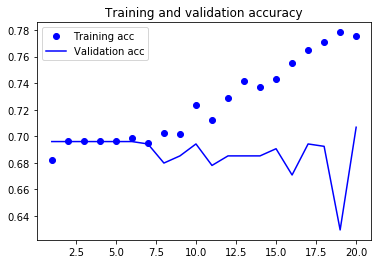

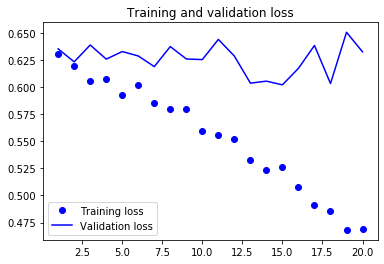

In [17]:
plot_graphs(history.history)

In [15]:
test_basal_dir = os.path.join(test_dir, 'basal')
test_basal_data = os.listdir(test_basal_dir)
test_basal_labels = ["basal" for _ in range(len(test_basal_data))]

test_squamous_dir = os.path.join(test_dir, 'squamous')
test_squamous_data = os.listdir(test_squamous_dir)
test_squamous_labels = ["squamous" for _ in range(len(test_squamous_data))]

test_basal_images = []
test_basal_metadata = []
for file in test_basal_data:
    image_directory = os.path.join(test_basal_dir, file)
    test_basal_images.extend(load_image(image_directory))

    name, _ = file.split('.')
    directory = os.path.join(base_database_directory, 'basal', name, f'{name}.json')
    with open(directory, 'r') as f:
        test_basal_metadata.append(json.load(f)['metadata']['clinical'])
        
        
test_squamous_images = []
test_squamous_metadata = []
for file in test_squamous_data:
    test_directory = os.path.join(test_squamous_dir, file)
    test_squamous_images.extend(load_image(image_directory))

    name, _ = file.split('.')
    directory = os.path.join(base_database_directory, 'squamous', name, f'{name}.json')
    with open(directory, 'r') as f:
        test_squamous_metadata.append(json.load(f)['metadata']['clinical'])
        
test_images = np.array(test_basal_images + test_squamous_images, dtype=np.float32)
test_metadata = test_basal_metadata + test_squamous_metadata

test_sex = extract_metadata(test_metadata, 'sex')
test_age = extract_metadata(test_metadata, 'age_approx')
test_position = extract_metadata(test_metadata, 'anatom_site_general')

test_sex = to_categorical(sex_encoder.transform(test_sex), len(sex_encoder.classes_))
test_age = to_categorical(age_encoder.transform(test_age), len(age_encoder.classes_))
test_position = to_categorical(position_encoder.transform(test_position), len(position_encoder.classes_))

test_labels = test_basal_labels + test_squamous_labels
test_labels = np.array([0 if label == 'basal' else 1 for label in test_labels], dtype=np.float32)

test_loss, test_acc = model.evaluate([test_sex, test_age, test_position, test_images], test_labels)
print('test loss:', test_loss)
print('test acc:', test_acc)

18/18 [==============================] - 10s 564ms/step - loss: 0.9457 - acc: 0.6547
test loss: 0.945695161819458
test acc: 0.6546762585639954


In [14]:
save_dict_as_json(history.history, "cancer_classification_metadata_history")
model.save("cancer_classification_metadata.h5")